# This notebook aims at showing how to generate experiments with experiment_generation, and how to retrieve the data in the more usual cases. 

In [1]:
import numpy as np
import scipy.linalg as SL
import os

%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(precision=2) # Only prints 3 significative digits

from qpt_pls import experiment_generation as EG
from qpt_pls import data_generation as DG
from qpt_pls import channels as Ch

In [3]:
from matplotlib import pyplot as plt

import matplotlib

# Let's first create a few channels.

#### Quantum Fourier Transforms on qubits, or a prime dimension for MUBs.

In [4]:
QFT_2qubits = Ch.QFTKraus(2**2)
QFT_5qubits = Ch.QFTKraus(2**5)
QFT_17 = Ch.QFTKraus(17)

In [5]:
QFT_2qubits.round(2) # round to get non-scientific notation and only a few decimals

array([[[ 0.5+0.j ,  0.5+0.j ,  0.5+0.j ,  0.5+0.j ],
        [ 0.5+0.j ,  0. +0.5j, -0.5+0.j , -0. -0.5j],
        [ 0.5+0.j , -0.5+0.j ,  0.5-0.j , -0.5+0.j ],
        [ 0.5+0.j , -0. -0.5j, -0.5+0.j ,  0. +0.5j]]])

> We see that a channel is a 3d array. <br>First dimension corresponds to the different Kraus operators, dimensions 2 and 3 are the Kraus operator.

#### Noisy QFT

In [6]:
noisy1_QFT_2qubits = Ch.add_disentanglement_noise(QFT_2qubits, level=.1)
noisy1_QFT_2qubits.round(2)

array([[[ 0.49+0.j  ,  0.49+0.j  ,  0.49+0.j  ,  0.49+0.j  ],
        [ 0.49+0.j  ,  0.  +0.49j, -0.49+0.j  , -0.  -0.49j],
        [ 0.49+0.j  , -0.49+0.j  ,  0.49-0.j  , -0.49+0.j  ],
        [ 0.49+0.j  , -0.  -0.49j, -0.49+0.j  ,  0.  +0.49j]],

       [[ 0.11+0.j  ,  0.11+0.j  ,  0.11+0.j  ,  0.11+0.j  ],
        [ 0.11+0.j  ,  0.  +0.11j, -0.11+0.j  , -0.  -0.11j],
        [-0.11+0.j  ,  0.11-0.j  , -0.11+0.j  ,  0.11-0.j  ],
        [-0.11+0.j  ,  0.  +0.11j,  0.11-0.j  , -0.  -0.11j]]])

> We have added to a QFT channel a measurement noise on the first qubit.<br>
The .1 is the level of noise. There is a 10% chance that the measurement is applied after the channel. We can change that level:

In [7]:
noisy5_QFT_2qubits = Ch.add_disentanglement_noise(QFT_2qubits, level=.5)
noisy5_QFT_2qubits.round(2)

array([[[ 0.43+0.j  ,  0.43+0.j  ,  0.43+0.j  ,  0.43+0.j  ],
        [ 0.43+0.j  ,  0.  +0.43j, -0.43+0.j  , -0.  -0.43j],
        [ 0.43+0.j  , -0.43+0.j  ,  0.43-0.j  , -0.43+0.j  ],
        [ 0.43+0.j  , -0.  -0.43j, -0.43+0.j  ,  0.  +0.43j]],

       [[ 0.25+0.j  ,  0.25+0.j  ,  0.25+0.j  ,  0.25+0.j  ],
        [ 0.25+0.j  ,  0.  +0.25j, -0.25+0.j  , -0.  -0.25j],
        [-0.25+0.j  ,  0.25-0.j  , -0.25+0.j  ,  0.25-0.j  ],
        [-0.25+0.j  ,  0.  +0.25j,  0.25-0.j  , -0.  -0.25j]]])

#### Sums of random unitary channels

In [8]:
# By default, KrausOp selects the unitary operators in the Sylvester-clock basis, according to their indices.
sum_unit_2qubits_rank2 = Ch.KrausOp(2**2, weights=[.3, .7], indices=[0,10])
# Now, with 32 times the same weight.
sum_unit_5qubits_rank32 = Ch.KrausOp(2**5, 32 * [1 / 32], indices=np.arange(0, 160, 5))

In [9]:
# We can also select among other unitary elements. `Ch.rand_unitary` is a uniformly random unitary. 
# The Kraus operators in this example will not be exactly orthogonal.
# We also use decreasing weights, rather than the same for each unitary.

def exp_weights(number=3, factor=2):
    """
    Generates weights summing to one, geometrically decreasing if $factor > 1$.
    """
    non_norm_w = factor**(-np.arange(number))
    return non_norm_w / non_norm_w.sum()

list_unitary = np.array([Ch.rand_unitary(17) for i in range(8)])
sum_unit_17_rank8 = Ch.KrausOp(17, weights=exp_weights(8, 1.5), indices=np.arange(8), us=list_unitary)
sq_norms_kr =  np.array([SL.norm(kr)**2 for kr in sum_unit_17_rank8])
sq_norms_kr, sq_norms_kr.sum()

(array([5.9 , 3.93, 2.62, 1.75, 1.16, 0.78, 0.52, 0.35]), 17.0)

#### Convex combination of channels

We can take convex combinations of channels with `Ch.convex_combi_channels`.<br>
No attempt is made at reducing the number of Kraus operators if more than the rank.

In [10]:
Ch.convex_combi_channels?

Signature: Ch.convex_combi_channels(d, weights, channels)
Docstring:
Makes a convex combination channels.

Input:
* d is the dimension of the underlying Hilbert space
* weights is an array-like with the weights of each channel. They 
must sum to one, and be non-negative.
* channels: list of channels
File:      ~/Dropbox/phd/process-tomography/Hyperplane_Intersection_Projection/src/qpt_pls/channels.py
Type:      function


In [11]:
combi_2qubits = Ch.convex_combi_channels(2**2, (.1, .9), (QFT_2qubits, sum_unit_2qubits_rank2))
combi_2qubits.round(2)

array([[[ 0.16+0.j  ,  0.16+0.j  ,  0.16+0.j  ,  0.16+0.j  ],
        [ 0.16+0.j  ,  0.  +0.16j, -0.16+0.j  , -0.  -0.16j],
        [ 0.16+0.j  , -0.16+0.j  ,  0.16-0.j  , -0.16+0.j  ],
        [ 0.16+0.j  , -0.  -0.16j, -0.16+0.j  ,  0.  +0.16j]],

       [[ 0.52+0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.52+0.j  ,  0.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ,  0.52+0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.52+0.j  ]],

       [[ 0.  +0.j  ,  0.  +0.j  ,  0.79+0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  , -0.79+0.j  ],
        [ 0.79-0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  , -0.79+0.j  ,  0.  +0.j  ,  0.  +0.j  ]]])

# Generating simulations and retrieving information
## What is saved.

We first generate a simulation with just a name and default parameters. We need to give only the name of the file (a `.h5` will be appended if there is none.), the dimension of the underlying space, and the channel.

In [12]:
if not os.path.exists('tutorial'):
    os.mkdir('tutorial') # Makes a directory to store examples

In [13]:
try:
    EG.generate_simulations('tutorial/sim1', 2**2, QFT_2qubits)
except AssertionError:
    pass
os.listdir('tutorial')

['sim8.h5',
 'sim14.h5',
 'sim10.h5',
 'sim11.h5',
 'sim9.h5',
 'sim2.h5',
 'sim6.h5',
 'sim7.h5',
 'sim3.h5',
 'sim4.h5',
 'sim1.h5',
 'sim5.h5',
 'sim12.h5',
 'sim13.h5']

We retrieve most of the information.

In [14]:
result = EG.retrieve_main('tutorial/sim1.h5')
result

{'sample_size': 301,
 'time_proj': 0.010037072000045555,
 'dist_L2': array([1.54, 0.64, 0.62, 0.61, 0.6 , 0.59, 0.59, 0.58, 0.53, 0.53, 0.52,
        0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52]),
 'dist_L1': array([5.18, 0.9 , 0.9 , 0.9 ]),
 'dist_Linfty': array([0.68, 0.45, 0.44, 0.45]),
 'least_ev': array([-0.66, -0.05, -0.04, -0.04, -0.04, -0.01, -0.01, -0.  , -0.  ]),
 'evs_error': array([[-6.77e-01, -5.58e-01, -4.72e-01, -3.43e-01, -2.58e-01, -1.55e-01,
         -1.06e-01, -2.19e-02,  1.64e-02,  7.87e-02,  2.32e-01,  2.92e-01,
          3.53e-01,  4.58e-01,  5.19e-01,  6.42e-01],
        [-4.50e-01, -6.02e-17, -3.20e-17, -2.58e-17, -1.68e-17, -9.12e-18,
         -7.24e-18, -1.44e-18,  3.24e-18,  7.72e-18,  1.06e-17,  1.57e-17,
          2.16e-17,  4.38e-17,  1.04e-16,  4.50e-01],
        [-4.44e-01, -1.18e-03, -9.07e-04, -9.07e-04, -7.80e-04, -4.24e-04,
         -4.24e-04,  4.32e-03,  7.85e-03,  9.76e-03,  9.76e-03,  2.76e-02,
          4.17e-02,  4.26e-02,  4.26e-02,  2.62e-01],
  

> We first store the sample size.<br>
dist_*  are the distances to the true channel. For the L2-distance, we have at first the LS estimator, then the first CP estimator, then each TP and CP estimator that appeared, and finally, the final pre-mixing estimator, and the final estimator.

> For the other distances, we have only the **LS, CP, final pre-mixing and final** estimators. By default, we do not compute those for the other estimates in the simulation.

> Then 'least_ev' is the least eigenvalue for the LS estimator, then each time we are on TP. If we show more digits, we will see it is not zero at the end.

In [15]:
np.set_printoptions(precision=10)
result['least_ev']

array([-0.6561892066, -0.051119244 , -0.0423779759, -0.0357493945,
       -0.0394968788, -0.007880876 , -0.0095668081, -0.0012247664,
       -0.0012247664])

In [16]:
np.set_printoptions(precision=2)

> Finally `evs_error` are the eigenvalues of the difference between the true channel and the estimator, again for
the four main estimates.

We can get many more explanations in the docstring of `EG.retrieve_main`.

In [17]:
EG.retrieve_main?

Signature:
EG.retrieve_main(
    fileh_name,
    exp_number=0,
    proj_type='HIPswitch',
    full_matrices=False,
)
Docstring:
Retrieves in a dictionary some of the information from a file created by 
generate_simulations.

Only one experiment repetition and projection type at a time. The experiment
number is exp_number, 0 by default.
The projection type is one of 'HIPswitch' (default), 'HIPrec', 'oneHIP', 'pureHIP',
'Alternate' or 'Dykstra'.

The output dictionary has the following entries:
* sample_size : the number of samples really taken.
* time_proj: the time taken by the projection, without the data generation and 
without the logging.
* 'dist_L2': vector of L2 distances between estimator and real channel. First
element is with respect to the LS estimator, second element is the first 
projection on CP, then each successive pair of elements are respectively on
TP and CP. Last two elements are the distance of the final estimator pre-mixing,
and that of the final estimator.
* 'dist

Let us make a few plots

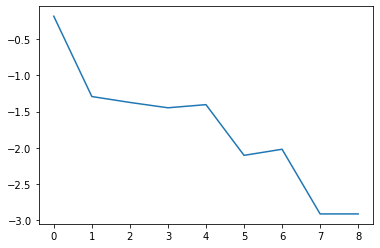

In [18]:
# Evolution of the least eigenvalue. TWO POINTS PER LOOP: on TP and on CP.

plt.plot(np.log10(-result['least_ev']))
plt.show()

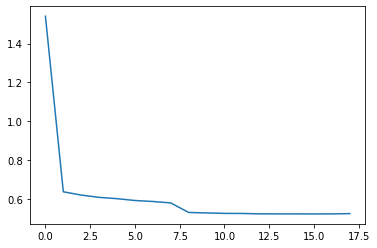

In [19]:
plt.plot(result['dist_L2'])

> Not very informative! That's because we have kept the LS estimator in there. Let's  remove it.

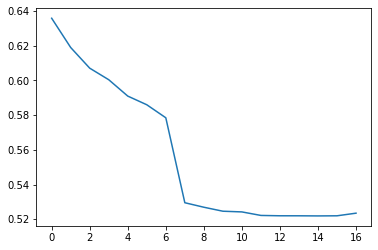

In [20]:
plt.plot(result['dist_L2'][1:])

> Better!<br>We see the jump when mixing the depolarizing channel at the end.
Maybe we want only one entry per loop (not both TP and CP), and keep only the TP entries (and the final premixing estimator):


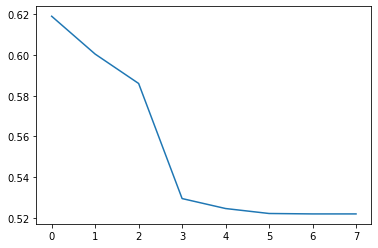

In [21]:
plt.plot(result['dist_L2'][2::2])

We can also check that the eigenvalues are consistent with the distances

In [22]:
np.abs(result['evs_error'][-1]).sum() == result['dist_L1'][-1]

True

#### That was fast, but there is a somewhat big jump when mixing the depolarizing channel.<br>
#### Let's change the tolerance. `depo_tol` is the absolute tolerance, `depo_rtol` the relative tolerance. They are maximum proportion of the channel to be mixed. The relative one is with respect to what should be a lower bound on the $L^\infty$ mistake: the least eigenvalue on the least-square estimator
#### If the tolerance is too small, the algorithm stops when `maxiter` is attained (default 300).

In [24]:
try:
    EG.generate_simulations('tutorial/sim2', 2**2, QFT_2qubits, depo_tol=1e-10)
except AssertionError:
    pass

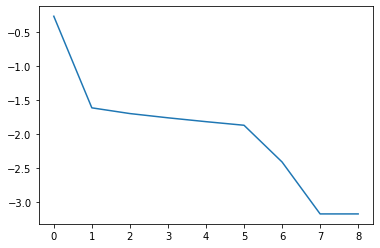

In [25]:
result2 = EG.retrieve_main('tutorial/sim2.h5')

plt.plot(np.log10(-result2['least_ev']))
plt.show()

> **Almost the same! What happened?** The code stops when either the absolute tolerance (default 1e-3), OR the relative tolerance (default 1e-1) is attained. Here we stop because of the relative tolerance. **Let's change both.**

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_26907/3147246866.py:7: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(-result3['least_ev']))


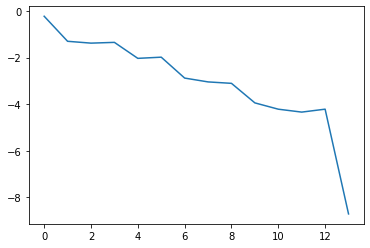

In [27]:
try:
    EG.generate_simulations('tutorial/sim3', 2**2, QFT_2qubits, depo_tol=1e-10, depo_rtol=1e-9)
except:
    pass
result3 = EG.retrieve_main('tutorial/sim3.h5')

plt.plot(np.log10(-result3['least_ev']))
plt.show()

> Now we're talking!

#### OK, now, how do I get more information?
> With `all_dists`, I can save the $L^1$ and $L^\infty$ distance at every step. CAREFUL: twice as long.<br>
> With `with_evs`, I also save the eigenvalues of the difference with the true channel at every step.<br>
> With `keep_key_channels`, I save the four main estimators.<br>
> With `save_intermediate`, I save all the intermediate channels. CAREFUL: can get very big on drive!

In [29]:
try:
    EG.generate_simulations('tutorial/sim4', 2**2, QFT_2qubits, depo_tol=1e-10, depo_rtol=1e-9, 
                        all_dists=True, with_evs=True, keep_key_channels=True, save_intermediate=True)
except AssertionError:
    pass

result4 = EG.retrieve_main('tutorial/sim4.h5')
result4

{'sample_size': 367,
 'time_proj': 0.020669959999793264,
 'dist_L2': array([1.26, 0.43, 0.41, 0.39, 0.38, 0.37, 0.37, 0.36, 0.31, 0.31, 0.31,
        0.31, 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 ]),
 'dist_L1': array([4.28, 0.61, 0.92, 0.75, 0.85, 0.71, 0.8 , 0.68, 0.59, 0.56, 0.58,
        0.56, 0.55, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54,
        0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54,
        0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54,
        0.54, 0.54]),
 'dist_Linfty': array([0.54, 0.31, 0.29, 0.28, 0.28, 0.27, 0.27, 0.27, 0.26, 0.26, 0.26,
        0.26, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27,
        0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27,
        0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27

> We see that we now have all the $L^1$ and $L^\infty$ distances, but where are my channels?<br>
> We need to add the option `full_matrices=True` to load them with `retrieve_main`

In [30]:
result4 = EG.retrieve_main('tutorial/sim4.h5', full_matrices=True)
result4

{'sample_size': 367,
 'time_proj': 0.020669959999793264,
 'dist_L2': array([1.26, 0.43, 0.41, 0.39, 0.38, 0.37, 0.37, 0.36, 0.31, 0.31, 0.31,
        0.31, 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 ]),
 'dist_L1': array([4.28, 0.61, 0.92, 0.75, 0.85, 0.71, 0.8 , 0.68, 0.59, 0.56, 0.58,
        0.56, 0.55, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54,
        0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54,
        0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54,
        0.54, 0.54]),
 'dist_Linfty': array([0.54, 0.31, 0.29, 0.28, 0.28, 0.27, 0.27, 0.27, 0.26, 0.26, 0.26,
        0.26, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27,
        0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27,
        0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27

Let's display the main ones. Notice that the true channel is already in Choi form here.

In [31]:
# WE FIRST DEFINE A HELPER FUNCTION

def plot_result_main(result, component='real'):
    """
    Plots the true channel, the LS, CP and final estimators.
    Either 'real' component, or 'imag' component.
    Same scale, LS will saturate.
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

    # We get the min and max from all three matrices (except LS that 
    # would blow the scale), so that we can use the same scale for 
    # everything. LS will saturate it.
    if component == 'real':
        true  = result['true'].real
        LS    = result['LS'].real
        CP    = result['CP'].real
        final = result['final'].real
    elif component == 'imag':
        true  = result['true'].imag
        LS    = result['LS'].imag
        CP    = result['CP'].imag
        final = result['final'].imag     
        
    combined_data = np.array([true, CP, final])
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    im = axes[0,0].imshow(true , vmin=_min, vmax=_max)
    axes[0,1].imshow(LS , vmin=_min, vmax=_max)
    axes[1,0].imshow(CP , vmin=_min, vmax=_max)
    axes[1,1].imshow(final, vmin=_min, vmax=_max)
        
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axes.flat])
    plt.colorbar(im, cax=cax, **kw)

    plt.show()

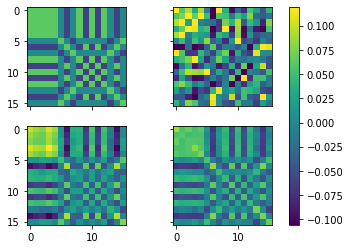

In [32]:
plot_result_main(result4, component='real')

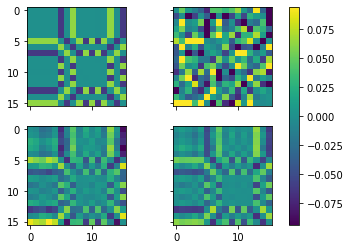

In [33]:
plot_result_main(result4, component='imag')

> We can see how much closer we get with CP, with respect to LS, and that the final estimator is pretty close to CP.<br>
We see that we are still somewhat far. **How do we change the sample size?**

## Changing the sample size and the channel

>We change sample size by setting the `cycles` variables. It is the mean number of cycles on setting, so that the sample size will have an average equal to $18^k cycles$ in Pauli mode, and $d(d+1) cycles$ in MUBs mode.

In [35]:
try:
    EG.generate_simulations('tutorial/sim5', 2**2, QFT_2qubits, cycles=100000/18**2, depo_tol=1e-10, depo_rtol=1e-9, 
                        all_dists=True, with_evs=True, keep_key_channels=True, save_intermediate=True)
except AssertionError:
    pass
result5 = EG.retrieve_main('tutorial/sim5.h5', full_matrices=True)
result5['sample_size']

99837

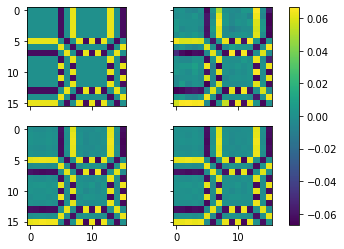

In [36]:
plot_result_main(result5, component='imag')

### Choosing a new channel
> Let's try a MUBs one! **We will get an error !!!**<br>
UNLESS we say we are in a `MUBs` scenario. `Pauli` is the default option.

In [37]:
try:
    EG.generate_simulations('tutorial/sim6', 17, sum_unit_17_rank8, scenario='MUBs', cycles=100000/(17 * 18),
                       keep_key_channels=True)
except:
    pass
result6 = EG.retrieve_main('tutorial/sim6.h5', full_matrices=True)
result6['sample_size']

99600

In [38]:
result6['dist_L1']

array([13.97,  0.76,  0.78,  0.78])

> Barely enough! But rank 8 with the square dimension 384, it's not that bad :)<br>
> And the graph below show we can guess the structure. By the way, you can zoom with the box. On all 4 graphs simultaneously.

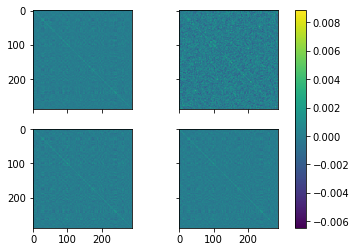

In [39]:
plot_result_main(result6, component='real')

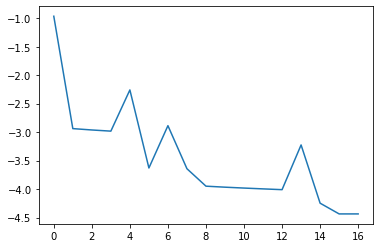

In [40]:
# A quick look at the convergence : Still only five or six iterations if we do not decrease the tolerance!
plt.plot(np.log10(-result6['least_ev']))

# Comparing projection algorithms

 We can choose the projections that are used with the parameter `projections`. Accepted values are 'HIPswitch' (default), 'Dykstra', 'Alternate', 'HIPrec', 'oneHIP' and 'pureHIP'. Details in the docstring of `generate_simulations`.

In [42]:
try:
    EG.generate_simulations('tutorial/sim7', 2**2, noisy1_QFT_2qubits, scenario='Pauli', depo_tol=1e-12, depo_rtol=1e-10,
                        projections=['HIPswitch', 'Dykstra', 'Alternate', 'HIPrec', 'oneHIP', 'pureHIP'],
                        all_dists=True, keep_key_channels=True)
except AssertionError:
    pass
result7 = EG.retrieve_main('tutorial/sim7.h5', full_matrices=True)

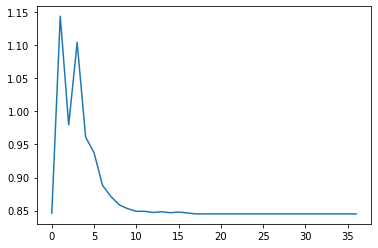

In [43]:
plt.plot(result7['dist_L1'][1:])

> OK, **why do we get only one line?**<br>
It's because `retrieve_main` only retrieves *one* simulation. And by default it is "HIPswitch". If we want another (even if there is only one), we need to tell it which projection to get.

In [44]:
result7_HIPswitch = EG.retrieve_main('tutorial/sim7.h5', proj_type='HIPswitch', full_matrices=True)
result7_Dykstra = EG.retrieve_main('tutorial/sim7.h5', proj_type='Dykstra', full_matrices=True)
result7_alt = EG.retrieve_main('tutorial/sim7.h5', proj_type='Alternate', full_matrices=True)
result7_pureHIP = EG.retrieve_main('tutorial/sim7.h5', proj_type='pureHIP', full_matrices=True)
result7_oneHIP = EG.retrieve_main('tutorial/sim7.h5', proj_type='oneHIP', full_matrices=True)
result7_HIPrec = EG.retrieve_main('tutorial/sim7.h5', proj_type='HIPrec', full_matrices=True)

We can compare the $L^1$ distances of the final estimator. They are essentially the same.

In [45]:
result7_HIPswitch['dist_L1'][-1], \
result7_Dykstra['dist_L1'][-1], \
result7_alt['dist_L1'][-1], \
result7_pureHIP['dist_L1'][-1], \
result7_oneHIP['dist_L1'][-1], \
result7_HIPrec['dist_L1'][-1]

(0.8450588941958643,
 0.8453607225743383,
 0.8432908572736035,
 0.8455914319868848,
 0.8435591231894101,
 0.8438250688629305)

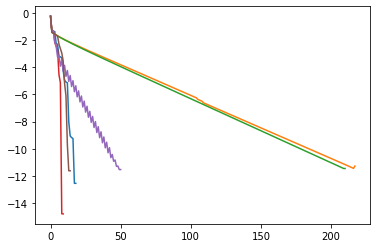

In [46]:

plt.plot(np.log10(- result7_HIPswitch['least_ev'])) # blue
plt.plot(np.log10(- result7_Dykstra['least_ev'])) # orange
plt.plot(np.log10(- result7_alt['least_ev'])) # green
plt.plot(np.log10(- result7_pureHIP['least_ev'])) # red
plt.plot(np.log10(- result7_oneHIP['least_ev'])) # purple
plt.plot(np.log10(- result7_HIPrec['least_ev'])) # brown

plt.show()

> Without surprise, the HIP variations perform best. oneHIP is the "original" algorithm with no memory, the purple line. On this easy two-qubit rank-three case, the pureHIP, without alternate projections, performs very well. HIPrec and other variations can often do 20% better than the default HIPswitch with default parameters. I keep them because they are very automatic (and we must stop somewhere !) 

**We can also have several times the same experiment (with different random data) on a single call of `generate_simulations`. We must likewise tell `retrieve_main` which one to take (default the first one 0).**

In [48]:
try:
    EG.generate_simulations('tutorial/sim8', 17, QFT_17, scenario='MUBs', depo_tol=1e-12, depo_rtol=1e-10,
                        repetitions=2, projections=['HIPrec'])
except AssertionError:
    pass
    
result8_0 = EG.retrieve_main('tutorial/sim8.h5', proj_type='HIPrec', exp_number=0)
result8_1 = EG.retrieve_main('tutorial/sim8.h5', proj_type='HIPrec', exp_number=1)

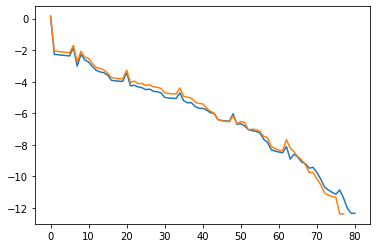

In [49]:

plt.plot(np.log10(- result8_0['least_ev'])) # blue
plt.plot(np.log10(- result8_1['least_ev'])) # orange

> Random variation can make things slightly  harder or easier.

# Changing projection parameters

As said formerly, changing parameters can lead to some improvement.<br>

**Options are passed to projections from `generate_simulations` as a dictionary `options_proj`. All projections will share the same options, but most are just ignored by all but one.**

HIPrec keeps memory of the hyperplane before the alternate projection sequences. Parameters are alt_steps (default 4), the length of the AP sequence, and HIP_steps (default 10; pretty short), the length of the HIP sequence.

In [50]:
rs = np.random.get_state() 

In [52]:
try:
    EG.generate_simulations('tutorial/sim9', 17, QFT_17, scenario='MUBs', depo_tol=1e-12, depo_rtol=1e-10,
                        repetitions=1, projections=['HIPrec'], options_proj={'alt_steps':4, 'HIP_steps':10},
                        random_state=rs)
except AssertionError:
    pass

try:
    EG.generate_simulations('tutorial/sim10', 17, QFT_17, scenario='MUBs', depo_tol=1e-12, depo_rtol=1e-10,
                        repetitions=1, projections=['HIPrec'], options_proj={'alt_steps':6, 'HIP_steps':30},
                        random_state=rs)
except AssertionError:
    pass

> Notice the use of `random_state` to get the same data.<br> 
I have not set up `generate_simulations` to use the same projection with different parameters, so we have to proceed in this way.<br>
**WARNING**: The data will probably not be the same on a different computer, it seems to depend on the version of numpy. Plus, my estimators are numerically unstable, so that the same data on two different computers give different results after a few iterations.

In [53]:
result9 = EG.retrieve_main('tutorial/sim9.h5', proj_type='HIPrec')
result10 = EG.retrieve_main('tutorial/sim10.h5', proj_type='HIPrec')

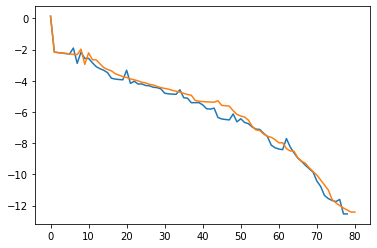

In [54]:
plt.plot(np.log10(- result9['least_ev'])) # blue
plt.plot(np.log10(- result10['least_ev'])) # orange

We see clearly that the spikes denoting the change from AP to HIP are more sparse when we have set `HIP_steps` to 30.

### Options to HIPswitch

We have two modes for switching from AP to HIP, and four modes for switching from HIP to AP.

First, from AP to HIP, set by `alt_to_HIP_switch`:
* 'counter' counts the number of steps in alternate projections. Parameter `alt_steps`. We will see further down that more complicated counters can be passed.
* 'cos' (default) changes when two alternate steps are almost aligned, namely until their cosinus exceeds a certain value. Parameter `min_cos`. Default $0.99$ .

In [56]:
try:
    EG.generate_simulations('tutorial/sim11', 17, QFT_17, scenario='MUBs', depo_tol=1e-12, depo_rtol=1e-10, 
                        repetitions=1, projections=['HIPswitch'], 
                        options_proj={'maxiter':100, 'alt_to_HIP_switch':'counter', 'alt_steps':10},
                        random_state=rs)
except AssertionError:
    pass

try:
    EG.generate_simulations('tutorial/sim12', 17, QFT_17, scenario='MUBs', depo_tol=1e-12, depo_rtol=1e-10,
                        repetitions=1, projections=['HIPswitch'], 
                        options_proj={'maxiter':100, 'alt_to_HIP_switch':'cos', 'min_cos':0.9999999 },
                        random_state=rs)
except AssertionError:
    pass
result11 = EG.retrieve_main('tutorial/sim11.h5', proj_type='HIPswitch')
result12 = EG.retrieve_main('tutorial/sim12.h5', proj_type='HIPswitch')

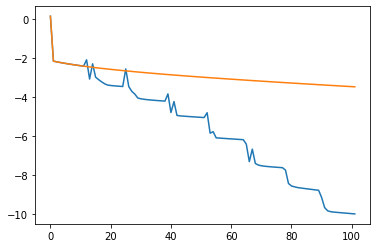

In [57]:
plt.plot(np.log10(- result11['least_ev'])) # blue
plt.plot(np.log10(- result12['least_ev'])) # orange

> We see on the blue line the flat parts that are ten loops long (=`alt_steps`), and on the orange part the poor performance since we forced it to stay on AP, since `min_cos`=0.9999999 was near-impossible to attain.

From HIP to AP, set by `HIP_to_alt_switch`:
* 'first' (default): takes no parameter. Switches when the first hyperplane of the sequance is no longer useful. Heuristically, its contribution has been solved.
* 'counter' counts the number of steps in HIP mode. Parameter `HIP_steps`. We will see further down that more complicated counters can be passed.
* 'missing': leaves when a total number of hyperplanes has been forgotten. Parameter `missing_w` (default 3).
* 'part'  : refinement on 'first'. Also leaves if the coefficient of the first hyperplane is small enough,  in proportion. Parameter `min_part` (default $0.1$).

We concentrate on 'first' and 'counter'

In [59]:
try:
    EG.generate_simulations('tutorial/sim13', 17, QFT_17, scenario='MUBs', depo_tol=1e-12, depo_rtol=1e-10,
            repetitions=1, projections=['HIPswitch'], 
            options_proj={'HIP_to_alt_switch':'counter', 'alt_to_HIP_switch':'counter', 'alt_steps':6, 'HIP_steps':30},
            random_state=rs)
except AssertionError:
    pass
result13 = EG.retrieve_main('tutorial/sim13.h5', proj_type='HIPswitch')


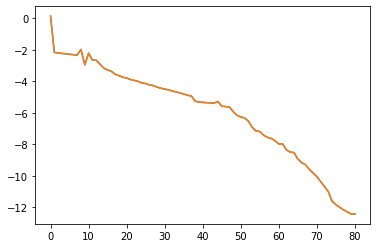

In [60]:
plt.plot(np.log10(- result10['least_ev'])) # blue
plt.plot(np.log10(- result13['least_ev'])) # orange

> We see that with both 'counter', HIPswitch is extremely close to HIPrec.<br>
**Notice that for 6 qubits, 'alt_steps':10 and 'HIP_steps':50 give better results than default. It might be a little slower on easy cases.**

### More complex counters

With HIPswitch (not HIPrec), we can use any generator as counter, so that the number of steps is not the same each time we enter a given mode. Passing it to `generate_simulations` is slightly more complicated (generators are not picklable, and I want to save the proj_options).

We need to give a function that yields a generator in the dictionary `steps`, with keywords `genfun_HIP` or `genfun_alt`. The parameters to this function (to be saved) are in `options_proj`, with keywords `genarg_HIP` and `genarg_alt` (which have default values). If given, it supersedes `alt_steps` and `HIP_steps`.

An example with a function `increasing_steps`: first parameter is the step, second (optional) is the start, third (optional) is the max, after which it stops increasing.

Since it is our last example, let's do **five qubits**!

In [14]:
try:
    EG.generate_simulations('tutorial/sim14', 2**5, QFT_5qubits, scenario='Pauli', depo_tol=1e-6, depo_rtol=1e-4,
            repetitions=1, projections=['HIPswitch'], 
            options_proj={'HIP_to_alt_switch':'counter', 'alt_to_HIP_switch':'counter', 
                            'genarg_alt':(4,4,10), 'genarg_HIP':(5,)},
            steps={'genfun_alt':EG.increasing_steps, 'genfun_HIP':EG.increasing_steps})
except AssertionError:
    pass
    
result14 = EG.retrieve_main('tutorial/sim14.h5', proj_type='HIPswitch')

Enters iteration 0


In [ ]:
plt.plot(np.log10(- result14['least_ev'])) # blue

Error: Kernel is dead

We see that the flat part grows at the start, then stays length 10, and the areas in between the flat parts grow longer and longer (5 more each time), without limit.